In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import keras
%matplotlib inline

C:\Users\Vaibhav\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
df = pd.read_csv('train_E6oV3lV.csv')

In [6]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
df.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [8]:
count_class_0, count_class_1 = df['label'].value_counts()

In [9]:
df_class_0 =  df.query('label==0')
df_class_1 =  df.query('label==1')

In [10]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1],ignore_index=True ,axis=0)

In [11]:
df_under.shape

(4484, 3)

In [12]:
df_under.groupby('label').count()

,id,tweet
label,,
0,2242,2242
1,2242,2242


In [13]:
X = df_under['tweet']
Y = df_under['label']
Y_org = Y

In [14]:
from keras.preprocessing.text import Tokenizer
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, char_level=False, oov_token=None)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=400)

In [15]:
max(df['tweet'], key=len)

' @user lmfao pathetic #soit   #growup #funny #noonethere #iknowwhoitis ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82â\x80¦'

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit(X).transform(X)

C:\Users\Vaibhav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 35)
pca.fit(X)
X = pca.transform(X);

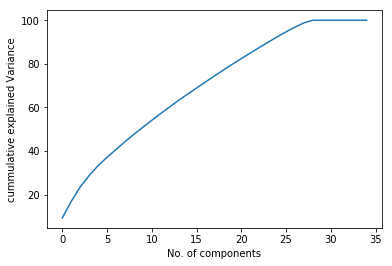

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state= 42)

In [20]:
from keras.models import Sequential 

In [21]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [22]:
classifier = Sequential()
classifier.add(LSTM(units=40, activation='relu',return_sequences= True, input_shape=(None, 35)))
classifier.add(Dropout(rate=0.3))

In [23]:
classifier.add(LSTM(units=20, return_sequences= True,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(LSTM(units=20,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(units = 2, activation='sigmoid'))

In [24]:
classifier.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [25]:
from sklearn.preprocessing import OneHotEncoder
y_e = OneHotEncoder()
Y_train_org = Y_train
Y_test_org = Y_test
Y_train =np.array(Y_train)
Y_test = np.array(Y_test)
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
y_e.fit(Y_train)
Y_train = y_e.transform(Y_train)
Y_test = y_e.transform(Y_test)

In [26]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0],1 ,X_test.shape[1]))
import tensorflow as tf
with tf.device('/gpu:0'):
    checker = classifier.fit(X_train_lstm, Y_train, batch_size=32, epochs=200, validation_data = (X_test_lstm, Y_test))


Train on 3587 samples, validate on 897 samples
Epoch 1/200
3587/3587 [==============================] - 3s 847us/step - loss: 0.6921 - acc: 0.5326 - val_loss: 0.6894 - val_acc: 0.5753
Epoch 2/200
3587/3587 [==============================] - ETA: 0s - loss: 0.6835 - acc: 0.606 - 1s 205us/step - loss: 0.6838 - acc: 0.6075 - val_loss: 0.6776 - val_acc: 0.6678
Epoch 3/200
3587/3587 [==============================] - 1s 198us/step - loss: 0.6689 - acc: 0.6553 - val_loss: 0.6852 - val_acc: 0.6683
Epoch 4/200
3587/3587 [==============================] - 1s 208us/step - loss: 0.6629 - acc: 0.6645 - val_loss: 0.6600 - val_acc: 0.6695
Epoch 5/200
3587/3587 [==============================] - 1s 216us/step - loss: 0.6443 - acc: 0.6614 - val_loss: 0.6671 - val_acc: 0.6711
Epoch 6/200
3587/3587 [==============================] - 1s 216us/step - loss: 0.6400 - acc: 0.6664 - val_loss: 0.6523 - val_acc: 0.6722
Epoch 7/200
3587/3587 [==============================] - 1s 222us/step - loss: 0.6367 - acc: 

Epoch 60/200
3587/3587 [==============================] - 1s 203us/step - loss: 0.5395 - acc: 0.7382 - val_loss: 0.6952 - val_acc: 0.6957
Epoch 61/200
3587/3587 [==============================] - 1s 195us/step - loss: 0.5367 - acc: 0.7451 - val_loss: 0.6764 - val_acc: 0.7040
Epoch 62/200
3587/3587 [==============================] - 1s 197us/step - loss: 0.5434 - acc: 0.7428 - val_loss: 0.6660 - val_acc: 0.6918
Epoch 63/200
3587/3587 [==============================] - 1s 194us/step - loss: 0.5270 - acc: 0.7499 - val_loss: 0.6811 - val_acc: 0.6929
Epoch 64/200
3587/3587 [==============================] - 1s 197us/step - loss: 0.5315 - acc: 0.7446 - val_loss: 0.6810 - val_acc: 0.6979
Epoch 65/200
3587/3587 [==============================] - 1s 194us/step - loss: 0.5299 - acc: 0.7505 - val_loss: 0.6893 - val_acc: 0.6962
Epoch 66/200
3587/3587 [==============================] - 1s 192us/step - loss: 0.5348 - acc: 0.7463 - val_loss: 0.6778 - val_acc: 0.6979
Epoch 67/200
3587/3587 [==========

3587/3587 [==============================] - 1s 194us/step - loss: 0.4560 - acc: 0.7834 - val_loss: 0.7153 - val_acc: 0.7285
Epoch 120/200
3587/3587 [==============================] - 1s 188us/step - loss: 0.4581 - acc: 0.7852 - val_loss: 0.7048 - val_acc: 0.7246
Epoch 121/200
3587/3587 [==============================] - 1s 186us/step - loss: 0.4426 - acc: 0.7906 - val_loss: 0.7419 - val_acc: 0.7313
Epoch 122/200
3587/3587 [==============================] - 1s 185us/step - loss: 0.4545 - acc: 0.7883 - val_loss: 0.7240 - val_acc: 0.7308
Epoch 123/200
3587/3587 [==============================] - 1s 185us/step - loss: 0.4479 - acc: 0.7887 - val_loss: 0.7133 - val_acc: 0.7258
Epoch 124/200
3587/3587 [==============================] - 1s 186us/step - loss: 0.4473 - acc: 0.7899 - val_loss: 0.7405 - val_acc: 0.7269
Epoch 125/200
3587/3587 [==============================] - 1s 184us/step - loss: 0.4501 - acc: 0.7837 - val_loss: 0.7311 - val_acc: 0.7291
Epoch 126/200
3587/3587 [================

3587/3587 [==============================] - 1s 196us/step - loss: 0.4067 - acc: 0.8062 - val_loss: 0.7501 - val_acc: 0.7386
Epoch 179/200
3587/3587 [==============================] - 1s 188us/step - loss: 0.4153 - acc: 0.8014 - val_loss: 0.7442 - val_acc: 0.7408
Epoch 180/200
3587/3587 [==============================] - 1s 198us/step - loss: 0.4200 - acc: 0.8110 - val_loss: 0.7261 - val_acc: 0.7525
Epoch 181/200
3587/3587 [==============================] - 1s 185us/step - loss: 0.4008 - acc: 0.8113 - val_loss: 0.7311 - val_acc: 0.7503
Epoch 182/200
3587/3587 [==============================] - 1s 181us/step - loss: 0.3995 - acc: 0.8141 - val_loss: 0.7566 - val_acc: 0.7480
Epoch 183/200
3587/3587 [==============================] - 1s 194us/step - loss: 0.4129 - acc: 0.8103 - val_loss: 0.7289 - val_acc: 0.7480
Epoch 184/200
3587/3587 [==============================] - 1s 200us/step - loss: 0.4070 - acc: 0.8068 - val_loss: 0.7252 - val_acc: 0.7480
Epoch 185/200
3587/3587 [================

In [27]:
Y_pred_test_label = classifier.predict(X_test_lstm)
y_pred_test=np.argmax(Y_pred_test_label,axis =1)
y_pred_test
Y_pred_train_label = classifier.predict(X_train_lstm)
y_pred_train = np.argmax(Y_pred_train_label,axis=1)
Y_test_true = Y_test_org.astype(np.int)
Y_train_true = Y_train_org.astype(np.int)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_true,y_pred_test))

             precision    recall  f1-score   support

          0       0.79      0.67      0.72       443
          1       0.72      0.82      0.77       454

avg / total       0.75      0.75      0.75       897



In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
### for softmax function
print("TRAIN:  \n",confusion_matrix(y_pred_train,Y_train_true))
print("\nTest:  \n",confusion_matrix(y_pred_test,Y_test_true))

TRAIN:  
 [[1362   95]
 [ 437 1693]]

Test:  
 [[297  80]
 [146 374]]


In [31]:
print(classification_report(Y_train_true,y_pred_train))

             precision    recall  f1-score   support

          0       0.93      0.76      0.84      1799
          1       0.79      0.95      0.86      1788

avg / total       0.87      0.85      0.85      3587

